In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import statsmodels.api as sm
import os
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import binom_test

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from helpers import *

mypal = make_aesthetic(with_gridlines=False)

# Read in data

In [50]:
df = pd.read_csv('../data/raw/qualtrics_solar_panel1.csv')
df = df.iloc[2:]

data_pts = []
for idx, row in df.iterrows():
    uid = row['ResponseId']
    duration = float(row['Duration (in seconds)'])/60
    age = row['age']
    gender = row['gender']
    educ = row['educ']
    commit = row['commitment']

    for i in range(1, 16):
        data_pt = {
            'uid': uid,
            'duration': duration,
            'age': age,
            'gender':gender,
            'educ':educ, 
            'commit':commit,
            'choice': row[f'{i}_lm']

        }
        data_pts.append(data_pt)


def clean_choice(x):
    if "Field/1" in x:
        return "Simulated\nFocus Group"
    elif "Field/2" in x:
        return "Zero Shot"
    else:
        raise ValueError
    
df = pd.DataFrame(data_pts)
df = df.dropna()
df['clean_choice'] = df['choice'].apply(clean_choice)
df['focus_chosen'] = df['clean_choice'].apply(lambda x: 1 if x=="Simulated\nFocus Group" else 0)

# assertions 
assert df['uid'].nunique()==20, "not 20 ppl"
assert df['clean_choice'].nunique()==2, "not 2 choices"
assert len(df)==300, "not 300 data pts"

df.to_csv('../data/processed/clean_solar_data.csv', index=False)

# Analysis

In [59]:
def print_ci(x):
    n = len(x)
    count = x.sum()
    lower, upper = proportion_confint(count=count, nobs=n, alpha=0.05)
    p = binom_test(count, n, 0.8)
    
    # Convert to percentages and format for LaTeX
    percent = count/n * 100
    lower_percent = lower * 100
    upper_percent = upper * 100
    
    print(f"{percent:.1f}\\% (95\\% CI = [{lower_percent:.1f}\\%, {upper_percent:.1f}\\%])")
    print(f"Binomial $p = {p}")


print_ci(df['focus_chosen'])

87.7\% (95\% CI = [83.9\%, 91.4\%])
Binomial $p = 0.0006547962565959734


# Plot

/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_57913/2402360835.py:13: UserWarning: The palette list has more values (15) than needed (2), which may not be intended.
  sns.barplot(x='clean_choice', y='proportion', data=choice_counts, hue='clean_choice', palette=mypal, width=0.4)


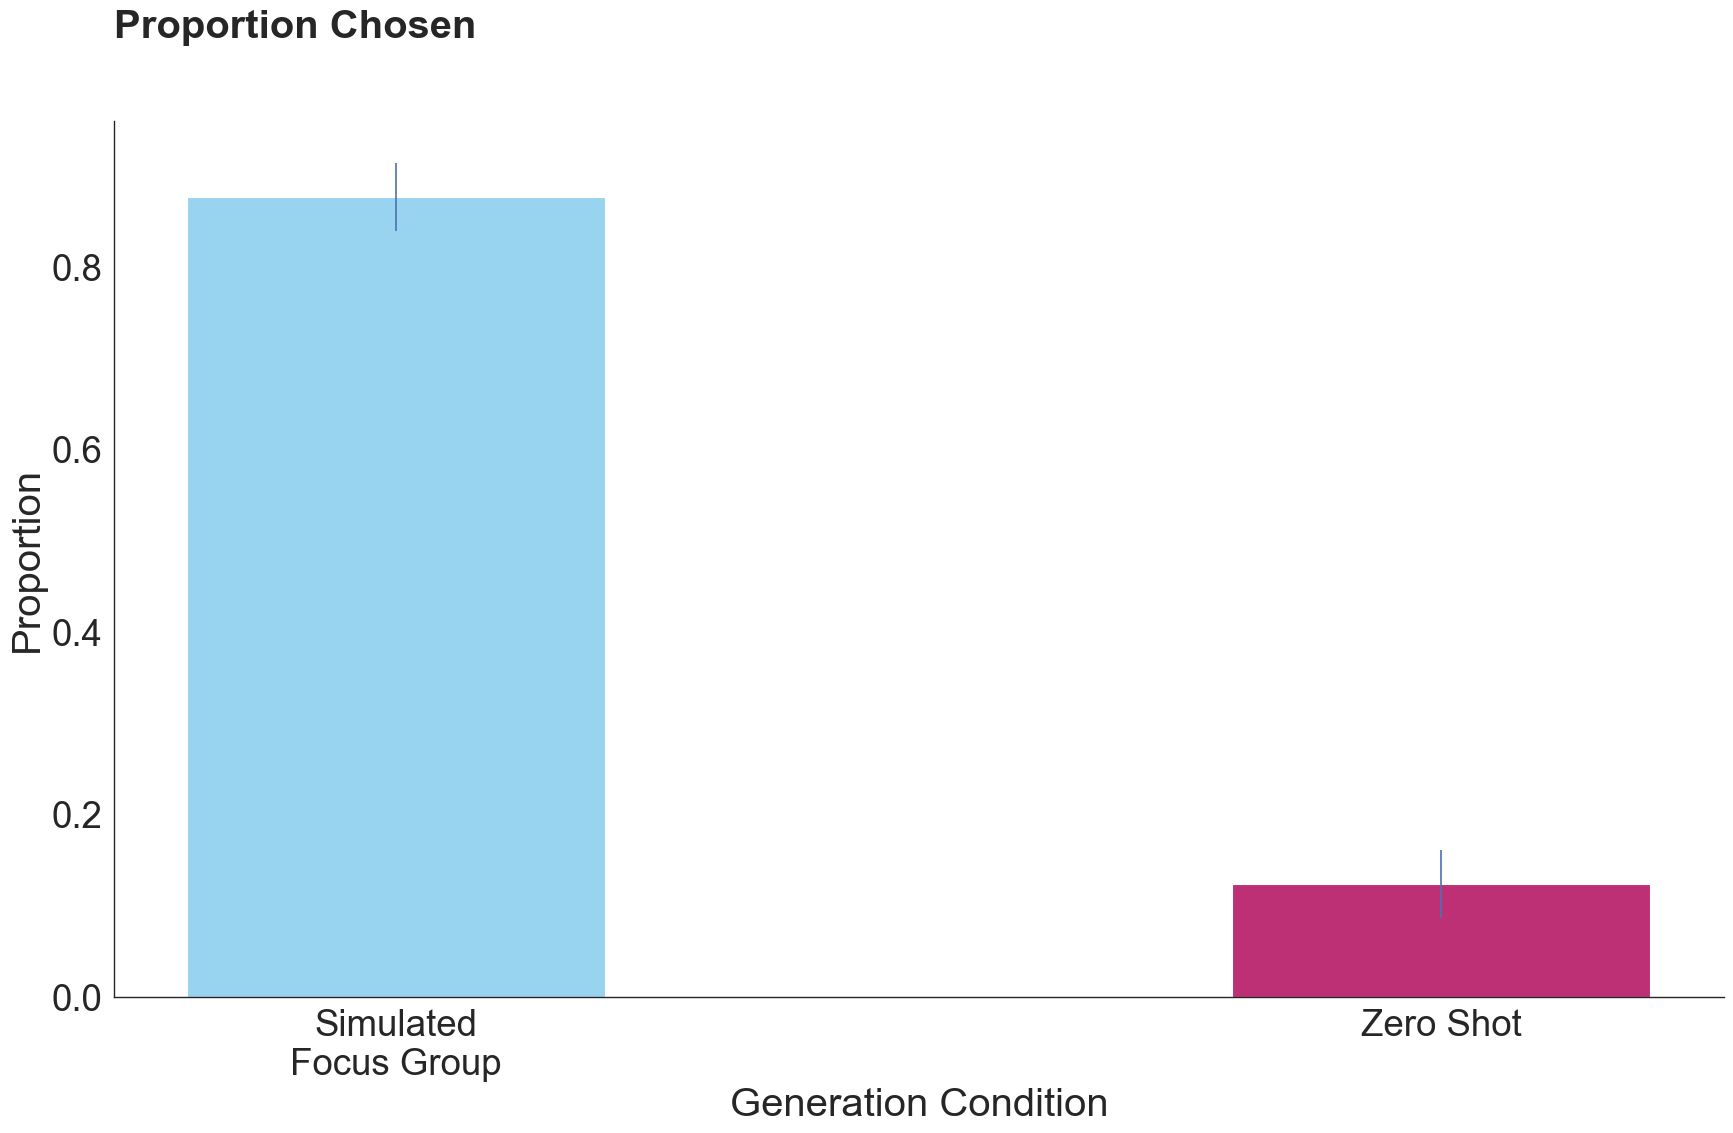

<Figure size 640x480 with 0 Axes>

In [58]:
choice_counts = df['clean_choice'].value_counts().reset_index(name='count')
choice_counts['proportion'] = choice_counts['count'] / len(df)
n = len(df)

choice_counts['ci_lower'], choice_counts['ci_upper'] = zip(*[
    sm.stats.proportion_confint(count, n, alpha=0.05, method='normal')
    for count in choice_counts['count']
])

# Plotting
make_aesthetic(font_scale=3)
plt.figure(figsize=(18, 12))
sns.barplot(x='clean_choice', y='proportion', data=choice_counts, hue='clean_choice', palette=mypal, width=0.4)
plt.errorbar(x=choice_counts.index, y=choice_counts['proportion'],
             yerr=[choice_counts['proportion'] - choice_counts['ci_lower'], 
                   choice_counts['ci_upper'] - choice_counts['proportion']], 
             fmt='none', c='b')
plt.xticks(rotation=0)
plt.title('Proportion Chosen', fontweight='bold')
plt.ylabel('Proportion')
plt.xlabel('Generation Condition')
plt.show()

plt.savefig('../plots/solar_panel.pdf', dpi=300, bbox_inches='tight')